In [19]:
from fastai.vision.all import *
import timm
from sklearn.metrics import roc_auc_score
import cv2
from sklearn.model_selection import StratifiedKFold, KFold
from sklearn.model_selection import train_test_split

In [20]:
path = Path('/home/azaidi/Desktop/kaggle/seti')
Path.BASE_PATH = path
path.ls()

(#10) [Path('kfold.ipynb'),Path('res50.ipynb'),Path('data'),Path('kf_sesresnext.ipynb'),Path('models'),Path('initial.ipynb'),Path('seti-breakthrough-listen.zip'),Path('.ipynb_checkpoints'),Path('filtered_data.ipynb'),Path('data_extract.ipynb')]

In [21]:
(path/'data/train').ls()

(#17) [Path('data/train/9'),Path('data/train/e'),Path('data/train/3'),Path('data/train/5'),Path('data/train/7'),Path('data/train/d'),Path('data/train/b'),Path('data/train/1'),Path('data/train/a'),Path('data/train/0')...]

In [22]:
(path/'data/train').ls()[0].ls()

(#3139) [Path('data/train/9/9f0dff2cd2b3.npy'),Path('data/train/9/91af44908241.npy'),Path('data/train/9/923ed9e2e4d8.npy'),Path('data/train/9/990f15496627.npy'),Path('data/train/9/92a91b53e5ee.npy'),Path('data/train/9/9567d242de97.npy'),Path('data/train/9/9f5cb9d7a0d6.npy'),Path('data/train/9/9aea15089923.npy'),Path('data/train/9/9deb1a9a72a5.npy'),Path('data/train/9/9e26f4ef6fc6.npy')...]

In [23]:
train_df = pd.read_csv(path/'data/train_labels.csv')
sub_df = pd.read_csv(path/'data/sample_submission.csv')
train_df.shape

(50165, 2)

In [24]:
data_path = path/'data'
train_df['path'] = train_df['id'].apply(lambda x: str(data_path/'train'/x[0]/x)+'.npy')

In [25]:
train_df.head(1)

,id,target,path
0,00034abb3629,0,/home/azaidi/Desktop/kaggle/seti/data/train/0/00034abb3629.npy


In [26]:
def kfold_idxs(df, n_splits):
    train_idx, val_idx = [], []
    skf = KFold(n_splits=n_splits, shuffle=True)
    for train_index, valid_index in skf.split(df.path, df.target):
        train_idx.append(train_index)
        val_idx.append(valid_index)
    return train_idx, val_idx

def get_val_idxs(df, n_splits):
    _, val_idxs = kfold_idxs(df, n_splits)
    return val_idxs

In [27]:
#v_idxs = get_val_idxs(train_df, 4)
#len(v_idxs)

In [28]:
class SETIDataset:
    def __init__(self, df):
        self.df = df
        
    def __len__(self):
        return len(self.df)

    def __getitem__(self, index):
        label = self.df.iloc[index].target
        filename = self.df.iloc[index].path
        data = np.load(filename).astype(np.float32)
        
        #this will return tensor of 256x819
        data = data[[0,2,4],:, :]
        
        #if line above commented out....
        #this will return a 256x1638 tensor per sample
        data = data.astype(np.float32)
        data = np.vstack(data).transpose((1, 0))
        
        #this will get you a 512x512 tensor per sample
        #data = np.vstack(data).transpose((1, 0))
        #data = cv2.resize(data, dsize=(512,512))     
        
        data_tensor = torch.tensor(data).float().unsqueeze(0)

        return (data_tensor, torch.tensor(label))
        #return data

In [40]:
t_df, v_df = train_test_split(train_df, test_size=0.1)

In [30]:
t_ds = SETIDataset(t_df)
t_ds[0][0].shape

torch.Size([1, 256, 819])

In [13]:
#v_idxs[0].shape, train_df.shape

In [13]:
#train_df.iloc[v_idxs[0]].shape, train_df.drop(v_idxs[0]).shape

In [14]:
#train_df.shape[0] == (train_df.iloc[v_idxs[0]].shape[0] + train_df.drop(v_idxs[0]).shape[0])

In [31]:
def get_dfs(df, v_idxs, fold):
    t_df = df.iloc[v_idxs[fold]].reset_index()
    v_df = df.drop(v_idxs[fold]).reset_index()
    return t_df, v_df

In [32]:
#t_df, v_df = get_dfs(train_df, v_idxs, 0)
#len(t_df), len(v_df)

In [33]:
#t_ds = SETIDataset(t_df)
#v_ds = SETIDataset(v_df)

In [34]:
#t_ds[0][0].shape

In [35]:
#sample = np.load(train_df.path[0])
#sample.shape

In [20]:
#np.vstack(sample).shape, np.vstack(sample).transpose((1,0)).shape

In [21]:
#bs = 64
#train_dl = torch.utils.data.DataLoader(t_ds, batch_size=bs,num_workers=8)
#valid_dl = torch.utils.data.DataLoader(v_ds, batch_size=bs,num_workers=8)

In [22]:
#len(train_dl), len(valid_dl)

In [23]:
#dls = DataLoaders(train_dl, valid_dl)

In [24]:
#batch = next(iter(dls.train))

In [25]:
#batch[0].shape

In [36]:
def roc_auc(preds,targ):
    try: return roc_auc_score(targ.cpu(),preds.squeeze().cpu())
    except: return 0.5

In [37]:
from timm import create_model
from fastai.vision.learner import _update_first_layer

def create_timm_body(arch:str, pretrained=True, cut=None, n_in=3):
    "Creates a body from any model in the `timm` library."
    model = create_model(arch, pretrained=pretrained, num_classes=0, global_pool='')
    _update_first_layer(model, n_in, pretrained)
    if cut is None:
        ll = list(enumerate(model.children()))
        cut = next(i for i,o in reversed(ll) if has_pool_type(o))
    if isinstance(cut, int): return nn.Sequential(*list(model.children())[:cut])
    elif callable(cut): return cut(model)
    else: raise NamedError("cut must be either integer or function")
        
def create_timm_model(arch:str, n_out, cut=None, pretrained=True, n_in=3, init=nn.init.kaiming_normal_, custom_head=None,
                     concat_pool=True, **kwargs):
    "Create custom architecture using `arch`, `n_in` and `n_out` from the `timm` library"
    body = create_timm_body(arch, pretrained, None, n_in)
    if custom_head is None:
        nf = num_features_model(nn.Sequential(*body.children()))
        head = create_head(nf, n_out, concat_pool=concat_pool, **kwargs)
    else: head = custom_head
    model = nn.Sequential(body, head)
    if init is not None: apply_init(model[1], init)
    return model.to('cuda')

def timm_learner(dls, arch:str, loss_func=None, pretrained=True, cut=None, splitter=None,
                y_range=None, config=None, n_in=3, n_out=None, normalize=True, **kwargs):
    "Build a convnet style learner from `dls` and `arch` using the `timm` library"
    if config is None: config = {}
    if n_out is None: n_out = get_c(dls)
    assert n_out, "`n_out` is not defined, and could not be inferred from data, set `dls.c` or pass `n_out`"
    if y_range is None and 'y_range' in config: y_range = config.pop('y_range')
    model = create_timm_model(arch, n_out, default_split, pretrained, n_in=n_in, y_range=y_range, **config)
    learn = Learner(dls, model, loss_func=loss_func, splitter=default_split, **kwargs)
    if pretrained: learn.freeze()
    return learn

In [41]:
#t_df, v_df = get_dfs(train_df, v_idxs, 0)
t_ds = SETIDataset(t_df)
v_ds = SETIDataset(v_df)
bs = 64
train_dl = torch.utils.data.DataLoader(t_ds, batch_size=bs,num_workers=8)
valid_dl = torch.utils.data.DataLoader(v_ds, batch_size=bs,num_workers=8)
dls = DataLoaders(train_dl, valid_dl)

In [ ]:
learn = timm_learner(dls, 'resnet50', pretrained=True,
                     n_in=1,n_out=1,metrics=[roc_auc], 
                     opt_func=ranger,
                     loss_func=BCEWithLogitsLossFlat()).to_fp16()
learn.fit_flat_cos(10, 5e-2, wd=0.1, cbs=[ReduceLROnPlateau(), GradientClip()])

epoch,train_loss,valid_loss,roc_auc,time
0,0.134574,0.177626,0.947199,04:36
1,0.121732,0.169096,0.960106,04:27
2,0.110737,0.172391,0.953194,04:27
3,0.105148,0.184568,0.961755,04:27
4,0.096440,0.089841,0.964184,04:27
5,0.096426,0.120201,0.968496,04:27
6,0.090861,0.139835,0.963792,04:27


Epoch 2: reducing lr to 0.005
Epoch 3: reducing lr to 0.005
Epoch 5: reducing lr to 0.005
Epoch 6: reducing lr to 0.005


In [22]:
learn = timm_learner(dls, 'tv_resnet101', pretrained=True,
                     n_in=1,n_out=1,metrics=[roc_auc], 
                     opt_func=ranger,
                     loss_func=BCEWithLogitsLossFlat()).to_fp16()
learn.fit_flat_cos(10, 5e-2, wd=0.1, cbs=[ReduceLROnPlateau(), GradientClip()])

epoch,train_loss,valid_loss,roc_auc,time
0,0.201167,0.266256,0.899883,04:28
1,0.145228,0.122883,0.945317,04:28
2,0.117852,0.183778,0.901145,04:28
3,0.108986,0.173399,0.943812,04:28
4,0.099247,0.090115,0.963015,04:27
5,0.091598,0.138657,0.958293,04:27
6,0.092004,0.103788,0.959678,04:27
7,0.076120,0.093534,0.964429,04:28
8,0.056806,0.086859,0.968227,04:28
9,0.035158,0.087190,0.970368,04:28


Epoch 2: reducing lr to 0.005
Epoch 3: reducing lr to 0.005
Epoch 5: reducing lr to 0.005
Epoch 6: reducing lr to 0.005
Epoch 7: reducing lr to 0.004531926864186965
Epoch 9: reducing lr to 1.0138444236362787e-07


In [21]:
learn = timm_learner(dls, 'tv_resnet50', pretrained=True,
                     n_in=1,n_out=1,metrics=[roc_auc], 
                     opt_func=ranger,
                     loss_func=BCEWithLogitsLossFlat()).to_fp16()
learn.fit_flat_cos(10, 5e-2, wd=0.1, cbs=[ReduceLROnPlateau(), GradientClip()])

epoch,train_loss,valid_loss,roc_auc,time
0,0.177263,0.127996,0.926707,02:55
1,0.122783,0.144048,0.948908,02:55
2,0.107837,0.096660,0.963208,02:55
3,0.094848,0.101284,0.958637,02:55
4,0.088309,0.079266,0.966229,02:55
5,0.081668,0.085433,0.964112,02:55
6,0.078821,0.125206,0.968242,02:55
7,0.066847,0.079471,0.970319,02:55
8,0.053981,0.079991,0.972431,02:55
9,0.031727,0.072140,0.972015,02:55


Epoch 1: reducing lr to 0.005
Epoch 3: reducing lr to 0.005
Epoch 5: reducing lr to 0.005
Epoch 6: reducing lr to 0.005
Epoch 7: reducing lr to 0.004531926864186965
Epoch 8: reducing lr to 0.0017427491811060811


In [23]:
learn = timm_learner(dls, 'resnetblur50', pretrained=True,
                     n_in=1,n_out=1,metrics=[roc_auc], 
                     opt_func=ranger,
                     loss_func=BCEWithLogitsLossFlat()).to_fp16()
learn.fit_flat_cos(10, 5e-2, wd=0.1, cbs=[ReduceLROnPlateau(), GradientClip()])

Downloading: "https://github.com/rwightman/pytorch-image-models/releases/download/v0.1-weights/resnetblur50-84f4748f.pth" to /home/azaidi/.cache/torch/hub/checkpoints/resnetblur50-84f4748f.pth


epoch,train_loss,valid_loss,roc_auc,time
0,0.160097,0.134901,0.914610,03:24
1,0.102755,0.103710,0.956087,03:20
2,0.084171,0.085815,0.962932,03:20
3,0.086908,0.161052,0.952695,03:20
4,0.071690,0.072737,0.968739,03:21
5,0.070645,0.076603,0.968740,03:21
6,0.061242,0.123135,0.965731,03:20
7,0.050773,0.093104,0.964890,03:20
8,0.043181,0.070830,0.973299,03:20
9,0.023956,0.068972,0.970337,03:20


Epoch 3: reducing lr to 0.005
Epoch 5: reducing lr to 0.005
Epoch 6: reducing lr to 0.005
Epoch 7: reducing lr to 0.004531926864186965


In [20]:
v_idxs = get_val_idxs(train_df, 4)
len(v_idxs)

4

In [21]:
models = ['tv_resnet50', 'resnet50', 'resnetblur50', 'tv_resnet101']

In [24]:
for x in range(len(v_idxs)):
    dls = get_dls(x)
    model = models[x]
    learn = timm_learner(dls,model, pretrained=True,
                     n_in=1,n_out=1,metrics=[roc_auc], 
                     opt_func=ranger,
                     loss_func=BCEWithLogitsLossFlat()).to_fp16()
    learn.fit_flat_cos(10, 5e-2, wd=0.1, cbs=[ReduceLROnPlateau(),GradientClip()])   
    learn.save(f'{model}_4_arch')

epoch,train_loss,valid_loss,roc_auc,time
0,0.188711,0.174675,0.868833,02:56
1,0.139876,0.112700,0.934155,02:52
2,0.117795,0.085185,0.962193,02:52
3,0.108435,0.108981,0.949925,02:52
4,0.097016,0.097044,0.948783,02:52
5,0.085803,0.078478,0.969511,02:52
6,0.086730,0.075794,0.969606,02:52
7,0.076289,0.074028,0.970114,02:53
8,0.059429,0.070681,0.970656,02:53
9,0.035884,0.065762,0.972564,02:53


Epoch 3: reducing lr to 0.005
Epoch 4: reducing lr to 0.005


epoch,train_loss,valid_loss,roc_auc,time
0,0.184855,0.158131,0.942006,02:57
1,0.122834,0.121987,0.966433,02:53
2,0.095367,0.084771,0.967495,02:54
3,0.084971,0.314548,0.967759,02:54
4,0.088969,0.450016,0.966510,02:54
5,0.070160,0.111427,0.970910,02:54
6,0.067402,0.123700,0.964680,02:54
7,0.064350,0.089834,0.970212,02:54
8,0.044965,0.079481,0.972292,02:54
9,0.026358,0.070928,0.976116,02:54


Epoch 3: reducing lr to 0.005
Epoch 4: reducing lr to 0.005
Epoch 5: reducing lr to 0.005
Epoch 6: reducing lr to 0.005
Epoch 7: reducing lr to 0.004531926864186965


epoch,train_loss,valid_loss,roc_auc,time
0,0.185766,0.122902,0.934834,03:23
1,0.109096,0.086962,0.956036,03:19
2,0.096715,0.090534,0.963164,03:19
3,0.084569,0.141433,0.970659,03:19
4,0.080550,0.074934,0.970403,03:19
5,0.066388,0.101373,0.967854,03:19
6,0.074420,0.075463,0.970337,03:19
7,0.058912,0.077087,0.969873,03:19
8,0.050201,0.063787,0.970898,03:19
9,0.028821,0.062981,0.970267,03:19


Epoch 2: reducing lr to 0.005
Epoch 3: reducing lr to 0.005
Epoch 5: reducing lr to 0.005
Epoch 6: reducing lr to 0.005
Epoch 7: reducing lr to 0.004531926864186965


epoch,train_loss,valid_loss,roc_auc,time
0,0.186678,0.217707,0.878099,04:27
1,0.129028,0.110165,0.940397,04:27
2,0.107463,0.134855,0.932835,04:27
3,0.105184,0.119938,0.951520,04:27
4,0.092680,0.091969,0.953754,04:27
5,0.084495,0.098164,0.941663,04:27
6,0.088484,0.081754,0.961860,04:27
7,0.076868,0.087681,0.958559,04:27
8,0.053988,0.077022,0.964041,04:27
9,0.031575,0.074764,0.967198,04:26


Epoch 2: reducing lr to 0.005
Epoch 3: reducing lr to 0.005
Epoch 5: reducing lr to 0.005
Epoch 7: reducing lr to 0.004531926864186965


In [39]:
learn = timm_learner(dls, models[1], pretrained=True,
                     n_in=1,n_out=1,metrics=[roc_auc], 
                     opt_func=ranger,
                     loss_func=BCEWithLogitsLossFlat()).to_fp16()

In [40]:
learn.fit_flat_cos(7, 5e-2, wd=0.1, cbs=[ReduceLROnPlateau()])

epoch,train_loss,valid_loss,roc_auc,time
0,0.144969,0.118387,0.948435,04:49
1,0.108329,0.104356,0.949275,04:42
2,0.088477,0.082407,0.968111,04:42
3,0.085495,0.086632,0.957437,04:42
4,0.063362,0.082593,0.963541,04:42
5,0.061572,0.068589,0.968420,04:42
6,0.032151,0.063606,0.974890,04:43


Epoch 3: reducing lr to 0.005
Epoch 4: reducing lr to 0.005


In [44]:
learn = timm_learner(dls, models[1], pretrained=True,
                     n_in=1,n_out=1,metrics=[roc_auc], 
                     opt_func=ranger,
                     loss_func=BCEWithLogitsLossFlat()).to_fp16()
learn.fit_flat_cos(7, 5e-2, wd=0.1, cbs=[ReduceLROnPlateau(), GradientClip()])

epoch,train_loss,valid_loss,roc_auc,time
0,0.138274,0.154023,0.939299,04:44
1,0.091558,0.107452,0.956277,04:45
2,0.076632,0.092022,0.964553,04:45
3,0.075380,0.104492,0.960337,04:45
4,0.073083,0.099821,0.962565,04:45
5,0.060635,0.067079,0.968163,04:45
6,0.034769,0.062346,0.973724,04:45


Epoch 3: reducing lr to 0.005
Epoch 4: reducing lr to 0.005


In [47]:
learn = timm_learner(dls, models[1], pretrained=True,
                     n_in=1,n_out=1,metrics=[roc_auc], 
                     opt_func=ranger,
                     loss_func=BCEWithLogitsLossFlat()).to_fp16()
learn.fit_flat_cos(9, 5e-2, wd=0.1, cbs=[ReduceLROnPlateau(), GradientClip()])

epoch,train_loss,valid_loss,roc_auc,time
0,0.138024,0.121086,0.948114,04:45
1,0.089119,0.119764,0.950397,04:45
2,0.082086,0.075595,0.968033,04:45
3,0.076499,0.141566,0.953625,04:45
4,0.077966,0.090702,0.964256,04:45
5,0.057654,0.094636,0.968837,04:45
6,0.053133,0.091768,0.969897,04:45
7,0.040822,0.068786,0.971372,04:45
8,0.023691,0.073926,0.970494,04:45


Epoch 3: reducing lr to 0.005
Epoch 4: reducing lr to 0.005
Epoch 5: reducing lr to 0.005
Epoch 6: reducing lr to 0.004853756257034318
Epoch 8: reducing lr to 8.550049324512754e-08


In [21]:
learn = timm_learner(dls, models[2], pretrained=True,
                     n_in=1,n_out=1,metrics=[roc_auc], 
                     opt_func=ranger,
                     loss_func=BCEWithLogitsLossFlat()).to_fp16()
learn.fit_flat_cos(7, 5e-2, wd=0.1, cbs=[ReduceLROnPlateau()])

epoch,train_loss,valid_loss,roc_auc,time
0,0.142960,0.148782,0.961476,02:54
1,0.099324,0.085574,0.969219,02:47
2,0.083973,0.073024,0.971810,02:47
3,0.078127,0.075033,0.977286,02:47
4,0.075097,0.066545,0.974138,02:47
5,0.059780,0.061478,0.976624,02:47
6,0.034456,0.057766,0.978101,02:47


Epoch 3: reducing lr to 0.005


In [23]:
def get_dls(fold, bs=64):
    t_df, v_df = get_dfs(train_df, v_idxs, fold)
    t_ds = SETIDataset(t_df)
    v_ds = SETIDataset(v_df)
    train_dl = torch.utils.data.DataLoader(t_ds, batch_size=bs,num_workers=8)
    valid_dl = torch.utils.data.DataLoader(v_ds, batch_size=bs,num_workers=8)
    dls = DataLoaders(train_dl, valid_dl)
    return dls

In [15]:
models = ['seresnext26d_32x4d', 'resnext50_32x4d', 'efficientnet_b2']

In [16]:
for x in range(len(v_idxs)):
    dls = get_dls(x)
    model = models[x]
    learn = timm_learner(dls,model, pretrained=True,
                     n_in=1,n_out=1,metrics=[roc_auc], 
                     opt_func=ranger,
                     loss_func=BCEWithLogitsLossFlat()).to_fp16()
    learn.fit_flat_cos(7, 5e-2, wd=0.1, cbs=[ReduceLROnPlateau()])   
    learn.save(f'{model}_3_arch')

epoch,train_loss,valid_loss,roc_auc,time
0,0.154700,0.135400,0.931842,03:54
1,0.109395,0.095061,0.956674,03:46
2,0.090867,0.091229,0.944933,03:46
3,0.085117,0.155419,0.954116,03:46
4,0.073753,0.078319,0.963635,03:46
5,0.063834,0.073552,0.972373,03:46
6,0.040367,0.060033,0.973985,03:46


Epoch 3: reducing lr to 0.005


epoch,train_loss,valid_loss,roc_auc,time
0,0.141549,0.113157,0.953514,04:45
1,0.088344,0.129568,0.936435,04:44
2,0.074998,0.067393,0.973439,04:45
3,0.065775,0.096621,0.955943,04:44
4,0.083768,0.081833,0.962531,04:44
5,0.058062,0.070456,0.967814,04:44
6,0.033454,0.058776,0.977189,04:44


Epoch 1: reducing lr to 0.005
Epoch 3: reducing lr to 0.005
Epoch 4: reducing lr to 0.005
Epoch 5: reducing lr to 0.0030730086227141722


epoch,train_loss,valid_loss,roc_auc,time
0,0.145882,0.082902,0.960596,02:54
1,0.099172,0.090179,0.957996,02:47
2,0.085595,0.083089,0.955636,02:47
3,0.078476,0.076766,0.968319,02:48
4,0.074623,0.073386,0.969891,02:47
5,0.065423,0.069890,0.969473,02:47
6,0.039989,0.062329,0.974409,02:47


Epoch 1: reducing lr to 0.005
Epoch 2: reducing lr to 0.005


SuggestedLRs(lr_min=6.30957365501672e-06, lr_steep=6.309573450380412e-07)

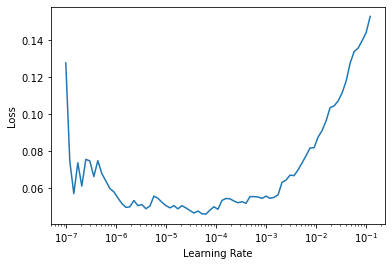

In [124]:
learn.unfreeze()
learn.lr_find()

In [125]:
learn.fit_flat_cos(3, slice(5e-5,5e-3), wd=0.1, cbs=[ReduceLROnPlateau()])

epoch,train_loss,valid_loss,roc_auc,time
0,0.067521,0.064040,0.971883,04:34
1,0.037071,0.074002,0.967997,04:34
2,0.016228,0.085814,0.969516,04:34


Epoch 1: reducing lr to 0.0005
Epoch 2: reducing lr to 3.694983898043167e-08


In [ ]:
#learn = learn.to_fp32()
#learn.save('eff3')